# Overview
This work is a simple comparison between two convolutional neural networks. 
1. A large network consisting of `BatchNormalization`, `Conv2D`, `MaxPooling2D`, and `Dropout` layers.
2. A smaller neural network consisting of just the `Conv2D` and `MaxPooling2D` layers.

We will consider their loss and accuracy curves to see which of the models will perform better.

# The DATA
The dataset we will be working with is the flower dataset downloaded from tensorflow utils. Now, what I did was to downloaded the data folder and unzip because I needed to create that realistic feeling of working with a real life collected data. The folder name is `flower_photos` and inside this folder contains the subfolder which holds the various types of flowers respectively. These subfolders are `sunflowers`, `roses`, `tulips`, `dandelion` and `daisy`. Inside each of these folders you will find the various pictures or images of the respective flowers. Basically, the file path will look like:

`Flower_photos
 daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
`

Normally, we could download and work with this data (our data, the `flower_photos`) automatically in our code since it is one of those datasets found in tensorflow utils. We can write the simple code below to dynamically download the data or folder itself:




```
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
```


However, like I pointed earlier on, I would like to make this look like having and working with a real world data. Imagine a situation whereby you were able to get images of different types of flowers and then created subfolders of an original folder (in our case `flower_photos`) bearing the names of each of the flowers and then storing all the respective images of the flowers in their respective folders. 

A very easy way to load the data in your local storage is to simply use the `image_dataset_from_directory` from `tensorflow.keras.utils`.



# Step 1: Loading Necessary Libraries
                                   

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

# Step 2: Creating the batch and image sizes of our dataset.

In [3]:
batch_size = 32
img_height = 256
img_width = 256

# Step 3: Creating the dataset for training

In the code below, we will simply use the `tf.keras.utils.image_dataset_from_directory` function to load our folder `flower_photos` which contains the subfolders containing all the five different type flower images. This is the first argument passed to the tensorflow function.

> Note that the five different subfolders represents the classes which are to be used for the classification by the models we will create


The other atrguments of the function `validation_split` is set at `0.2` meaning that **20%** of our data will be set aside for validation or testing of the model while the remaining **80%** will be used to train the model. 

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
 "../input/flower-photos-by-the-tensorflow-team/flower_photos",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-10-31 06:56:05.744931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:56:05.829708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:56:05.830466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:56:05.834108: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

We can see the output from above reads that the files belong to 5 classes. This simply means that the images of our data belongs to these classes.

# Step 4: Creating the dataset for Validation 
In the code below, we are creating the validation data set by setting aside only 20% for validation or testing on our model.

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "../input/flower-photos-by-the-tensorflow-team/flower_photos",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


# Step 5: Getting the class names of our images

In [6]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Step 6: Visualizing some samples of our data

2022-10-31 06:56:08.358219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


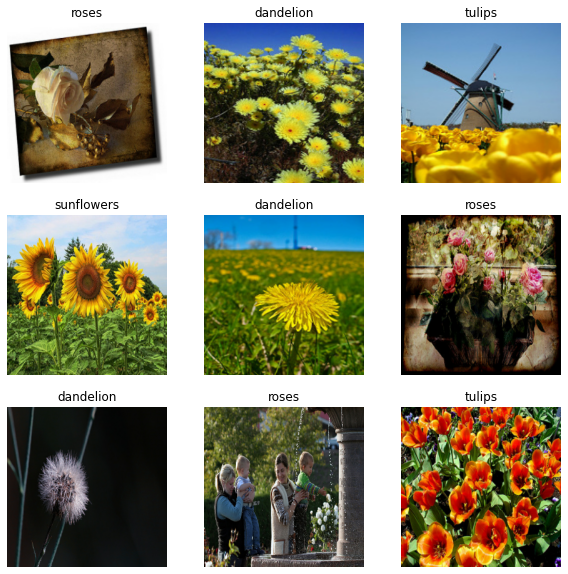

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Step 7: Rescaling our images

Normally, RGB channel values are in the values ***0*** to ***255***, but a high value will not be good for a neural network. A neural network works best with very low values, values between ***0*** and ***1***.

In [8]:
train_ds.as_numpy_iterator().next()[0].max()

255.0

In [9]:
train_ds = train_ds.map(lambda x,y: (x/255, y))

In [10]:
train_ds.as_numpy_iterator().next()[0].max()

1.0

In [11]:
train_ds.as_numpy_iterator().next()[0].min()

0.0

In [12]:
val_ds.as_numpy_iterator().next()[0].max()

255.0

In [13]:
val_ds.as_numpy_iterator().next()[0].min()

0.0

In [14]:
val_ds = val_ds.map(lambda x,y: (x/255, y))

In [15]:
val_ds.as_numpy_iterator().next()[0].max()

1.0

# Step 8: Configuring our Dataset for a Better Performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Step 9: Creating a Large Neural Network
Our first model will be a Large one with many layers. We will also do some bit of data augmentation to our existing data.

In [17]:
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

model_1 = keras.Sequential([
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),    
    #preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),layers.Conv2D(32, 3, activation='relu'),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax'),
])

# Step 10: Model Compiling
Here we choose our optimizer, loss and metrics for the model. At the end, we would like to know how good is the accuracy of our model with regards to the training data and validation data.

In [18]:
model_1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Step 11: Model Training

In [19]:
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-10-31 06:56:18.172508: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


92/92 [==============================] - 23s 149ms/step - loss: 1.7232 - accuracy: 0.3883 - val_loss: 13.9014 - val_accuracy: 0.1703
Epoch 2/50
92/92 [==============================] - 9s 102ms/step - loss: 2.0690 - accuracy: 0.4060 - val_loss: 23.4138 - val_accuracy: 0.3134
Epoch 3/50
92/92 [==============================] - 9s 101ms/step - loss: 11.5425 - accuracy: 0.3610 - val_loss: 7.7459 - val_accuracy: 0.4537
Epoch 4/50
92/92 [==============================] - 9s 101ms/step - loss: 4.5932 - accuracy: 0.3988 - val_loss: 4.5866 - val_accuracy: 0.3992
Epoch 5/50
92/92 [==============================] - 9s 101ms/step - loss: 1.3615 - accuracy: 0.4758 - val_loss: 1.6892 - val_accuracy: 0.4401
Epoch 6/50
92/92 [==============================] - 9s 102ms/step - loss: 1.1644 - accuracy: 0.5381 - val_loss: 1.4611 - val_accuracy: 0.5477
Epoch 7/50
92/92 [==============================] - 9s 101ms/step - loss: 1.0249 - accuracy: 0.5783 - val_loss: 1.8907 - val_accuracy: 0.5150
Epoch 8/50
92

# Step 12: Loss and Accuracy Curve

<AxesSubplot:>

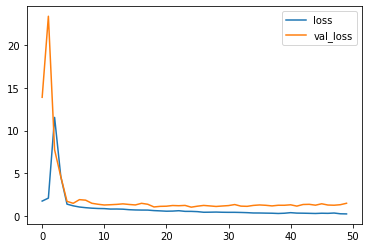

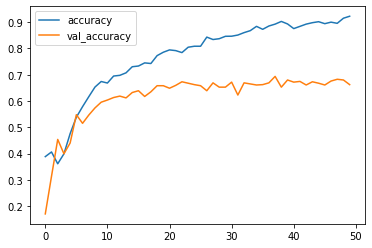

In [20]:
import pandas as pd

history_frame_1 = pd.DataFrame(history_1.history)
history_frame_1.loc[:, ["loss", "val_loss"]].plot()
history_frame_1.loc[:, ["accuracy", "val_accuracy"]].plot()

# Insight
We can see from the above plot that the model learnt a lot from the training data with an accuracy of 96% on training but with an accuracy of 72% on testing. This is not so bad. Also, since the `val_loss` (validation loss) is greater than the `loss` (training loss), it shows that the model is overfitting.

# Step 13: Creating a Small Neural Network and Training
Our second model will be a small and very simple one with some layers.

In [21]:
model_2 = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu'),
  
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5,activation='softmax')
])

In [22]:
model_2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
92/92 [==============================] - 3s 29ms/step - loss: 1.4363 - accuracy: 0.4005 - val_loss: 1.1569 - val_accuracy: 0.5300
Epoch 2/50
92/92 [==============================] - 2s 26ms/step - loss: 1.0004 - accuracy: 0.6131 - val_loss: 1.0009 - val_accuracy: 0.6022
Epoch 3/50
92/92 [==============================] - 2s 27ms/step - loss: 0.8340 - accuracy: 0.6727 - val_loss: 0.9580 - val_accuracy: 0.6308
Epoch 4/50
92/92 [==============================] - 2s 26ms/step - loss: 0.5914 - accuracy: 0.7847 - val_loss: 1.0943 - val_accuracy: 0.6117
Epoch 5/50
92/92 [==============================] - 2s 26ms/step - loss: 0.3553 - accuracy: 0.8859 - val_loss: 1.6071 - val_accuracy: 0.6144
Epoch 6/50
92/92 [==============================] - 2s 26ms/step - loss: 0.2402 - accuracy: 0.9213 - val_loss: 1.6387 - val_accuracy: 0.6063
Epoch 7/50
92/92 [==============================] - 2s 27ms/step - loss: 0.1808 - accuracy: 0.9390 - val_loss: 2.0389 - val_accuracy: 0.5913
Epoch 8/50
92

# Step 14: Loss and Accuracy Curve

<AxesSubplot:>

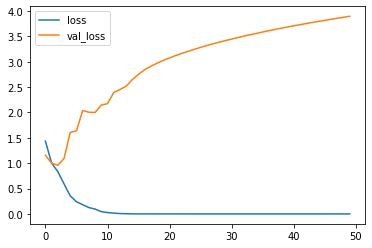

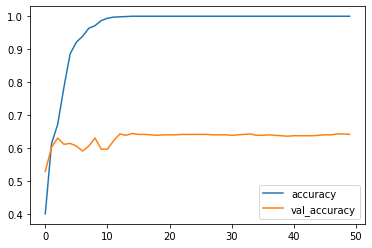

In [24]:
import pandas as pd

history_frame_2 = pd.DataFrame(history_2.history)
history_frame_2.loc[:, ["loss", "val_loss"]].plot()
history_frame_2.loc[:, ["accuracy", "val_accuracy"]].plot()

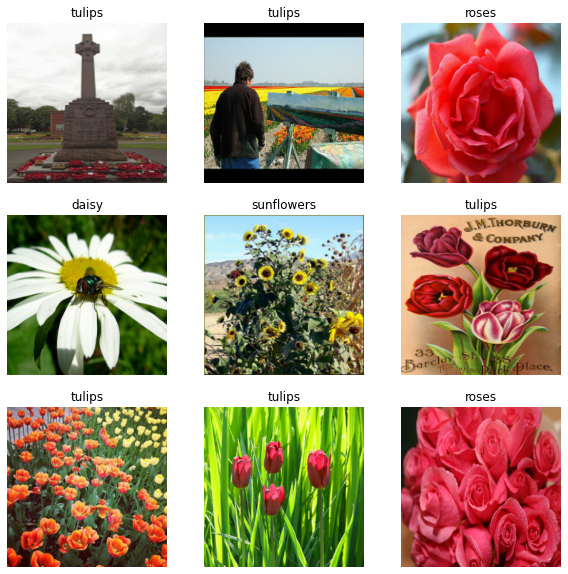

In [25]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    

In [26]:
from tensorflow.keras.preprocessing import image

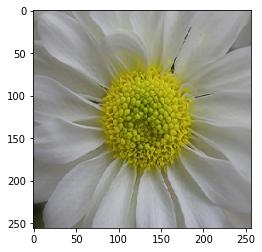

In [27]:
img_path = "../input/flower-photos-by-the-tensorflow-team/flower_photos/daisy/100080576_f52e8ee070_n.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
plt.show()

In [28]:
from tensorflow.keras.preprocessing import image

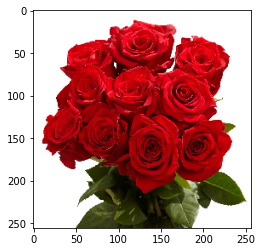

In [29]:
img = image.load_img("../input/roses-picture/61uMSGiTPL._SL1000_.jpg", target_size=(256, 256))
plt.imshow(img)
plt.show()

In [30]:
import cv2

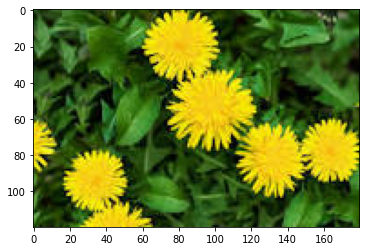

In [31]:
img_1 = cv2.imread("../input/dandelionimage/images.jfif")
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
plt.show()

In [35]:
names_of_classes = tf.keras.utils.image_dataset_from_directory(
 "../input/flower-photos-by-the-tensorflow-team/flower_photos",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size).class_names
names_of_classes = np.array(names_of_classes)
names_of_classes

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [37]:
img_1 = cv2.imread("../input/flower-photos-by-the-tensorflow-team/flower_photos/tulips/112951022_4892b1348b_n.jpg")
img_1 = tf.image.resize(img_1, (256, 256))
img_1.shape


TensorShape([256, 256, 3])

In [38]:
names_of_classes
prediction = model_1.predict(np.expand_dims(img_1/255, 0))
prediction = np.argmax(prediction, axis=1)[:]
if prediction == 0:
    print(f"This is a {names_of_classes[0]} flower")
elif prediction ==1:
    print(f'This is a {names_of_classes[1]} flower')
elif prediction == 2:
    print(f'This is a {names_of_classes[2]} flower')
elif prediction == 3:
    print(f'This is a {names_of_classes[3]} flower')
elif prediction == 4:
    print(f'This is a {names_of_classes[4]} flower')

This is a tulips flower


In [40]:
from tensorflow.keras.models import load_model

In [42]:
model_1.save("flowerprediction.h5")